In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import search
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [2]:
ROOT = Path().resolve().parent    # go up one level from src/
RAW = ROOT / "data" / "raw"
PROCESSED = ROOT / "data" / "processed" 

DATA_MODEL = pd.read_parquet(PROCESSED / "FULL_MODEL_INPUTS_OUTPUT.parquet")
DATA_MODEL

,year,PERMNO,DQS,PRS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap,sigma_idio_ann
0,2016,10001,0.454567,0.490094,0.350717,0.470850,-0.001340,0.002598,0.005519,0.704081,0.032737,4.882999,0.409311
1,2017,10001,0.971758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,10025,0.884946,-0.021613,0.345171,0.288546,-0.108072,0.073356,0.254228,0.190812,0.009362,6.386434,0.469507
3,2017,10025,0.928386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,10026,0.717028,-0.021613,0.002024,0.807065,0.064006,0.096112,0.119088,0.255728,0.195058,7.821940,0.178008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76738,2020,93436,0.478218,0.795722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.585316
76739,2021,93436,0.456581,0.795722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390072
76740,2022,93436,0.461577,0.795722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326525
76741,2023,93436,0.926950,0.795722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255409


In [3]:
model_df = DATA_MODEL.copy()
model_df = model_df.sort_values(by=["year", "PERMNO"]).reset_index(drop=True)
model_df = model_df[model_df["DQS"] > 0]
model_df["PRSxDQS"] = model_df["PRS"] * model_df["DQS"]

target_col = "sigma_idio_ann"

feature_cols = [
    "PRS",
    "DQS",
    "PRSxDQS",
    "leverage",
    "equity_ratio",
    "asset_growth",
    "ROA",
    "ROE",
    "book-to-market",
    "cash_ratio",
    "log_mktcap",
]

# Drop rows with missing target or any missing feature (simple baseline)
model_df = model_df.dropna(subset=[target_col] + feature_cols).copy()
 
# PERMNO_10026 = model_df[model_df["PERMNO"]==10026]
# PERMNO_10026

# 1. Isolate the "Production Set" (Data from 2024) for portfolio illustration
#    These are the 10-Ks filed in 2024. We want to know which ones predict high risk for 2025.
production_mask = model_df["year"] == 2024
X_production = model_df.loc[production_mask, feature_cols]
identifiers_production = model_df.loc[production_mask, ["PERMNO", "DQS", "PRS"]]
X_production

,PRS,DQS,PRSxDQS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap
67070,-0.021613,0.752542,-0.016265,0.117575,0.701025,0.068793,0.063403,0.090443,0.316707,0.053765,8.013549
67071,0.795722,0.914193,0.727443,0.235906,0.676153,0.059831,0.086773,0.128333,0.282088,0.264659,5.229242
67075,0.545741,0.029777,0.016251,0.032063,0.752290,-0.179300,-0.084846,-0.112783,0.608695,0.801734,4.055978
67079,0.316768,0.670041,0.212248,0.025074,0.767919,0.097176,0.155886,0.202998,0.411774,0.201373,10.131577
67081,-0.182495,0.472951,-0.086311,0.543145,0.243651,0.119752,0.013648,0.056016,1.252872,0.042857,6.695455
...,...,...,...,...,...,...,...,...,...,...,...
73986,0.795722,0.337449,0.268515,0.095746,0.081660,-0.027039,0.012383,0.151644,0.297496,0.167355,11.788379
73996,0.180817,0.911157,0.164752,0.000000,0.998639,-0.020653,0.208084,0.208367,0.483363,0.000000,8.343695
74000,0.490094,0.777950,0.381268,0.365777,0.438032,-0.028000,-0.003732,-0.008521,1.376889,0.015217,8.108972
74004,-0.250812,0.882933,-0.221450,0.194300,0.717831,0.127421,0.109762,0.152908,0.923878,0.090966,8.624290


# Create Data Set with a lag on the volatility

In [4]:
# 1. Sort is critical: Ensure data is ordered by Firm and Year
model_df = model_df.sort_values(by=['PERMNO', 'year'])

# 2. Create the Future Target (y_t+1)
#    We Group by PERMNO so we don't accidentally shift one firm's data into another's.
#    .shift(-1) moves the NEXT row's value up to the CURRENT row.
model_df['sigma_idio_next'] = model_df.groupby('PERMNO')['sigma_idio_ann'].shift(-1)

# 3. Sanity Check
#    Let's look at a specific firm to ensure 2016's row has 2017's volatility.
print("--- Data Structure Check ---")
print(model_df[['PERMNO', 'year', 'sigma_idio_ann', 'sigma_idio_next']].head(10))

# 4. Clean Up
#    The last year for every company will now have NaN for 'sigma_idio_next' 
#    (because there is no future year to pull from). We must drop these rows.
model_df_predictive = model_df.dropna(subset=['sigma_idio_next']).copy()

print(f"\nOriginal Size: {len(model_df)}")
print(f"Predictive Size: {len(model_df_predictive)} (Last years dropped)")

--- Data Structure Check ---
       PERMNO  year  sigma_idio_ann  sigma_idio_next
0       10001  2016        0.409311              NaN
1       10025  2016        0.469507              NaN
2       10026  2016        0.178008         0.084315
7607    10026  2017        0.084315         0.097474
15284   10026  2018        0.097474         0.152821
23084   10026  2019        0.152821         0.094212
31041   10026  2020        0.094212         0.180791
39166   10026  2021        0.180791         0.277304
48055   10026  2022        0.277304         0.082433
57610   10026  2023        0.082433         0.134573

Original Size: 9922
Predictive Size: 8137 (Last years dropped)


In [5]:
PERMNO_10026_new = model_df_predictive[model_df_predictive["PERMNO"]==10026]
PERMNO_10026_new

,year,PERMNO,DQS,PRS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap,sigma_idio_ann,PRSxDQS,sigma_idio_next
2,2016,10026,0.717028,-0.021613,0.002024,0.807065,0.064006,0.096112,0.119088,0.255728,0.195058,7.821940,0.178008,-0.015497,0.084315
7607,2017,10026,0.738369,-0.021613,0.001434,0.786785,0.097081,0.091295,0.116036,0.240732,0.173051,7.949572,0.084315,-0.015958,0.097474
15284,2018,10026,0.714495,-0.021613,0.001156,0.814464,0.074704,0.111153,0.136474,0.279640,0.142194,7.906375,0.097474,-0.015442,0.152821
23084,2019,10026,0.785760,-0.021613,0.001037,0.817933,0.093696,0.093020,0.113726,0.239398,0.238867,8.155564,0.152821,-0.016983,0.094212
31041,2020,10026,0.723113,-0.021613,0.058282,0.766169,0.036508,0.017325,0.022613,0.274854,0.233741,7.987930,0.094212,-0.015629,0.180791
39166,2021,10026,0.734013,-0.021613,0.053934,0.753555,0.062151,0.049551,0.065756,0.280454,0.259461,8.011454,0.180791,-0.015864,0.277304
48055,2022,10026,0.797753,-0.021613,0.091672,0.709279,0.084428,0.038814,0.054723,0.299839,0.032205,7.965120,0.277304,-0.017242,0.082433
57610,2023,10026,0.750618,-0.021613,0.095448,0.713665,0.049525,0.061779,0.086565,0.281593,0.038819,8.082402,0.082433,-0.016223,0.134573


# Random Forest (Predictive)

In [6]:
# DataFrame for Sample 1A
model_df = model_df_predictive.copy()

target_col = "sigma_idio_next"

feature_cols = [
    "PRS",
    "DQS",
    "PRSxDQS",
    "leverage",
    "equity_ratio",
    "asset_growth",
    "ROA",
    "ROE",
    "book-to-market",
    "cash_ratio",
    "log_mktcap",
]

# Drop rows with missing target or any missing feature (simple baseline)
model_df = model_df.dropna(subset=[target_col] + feature_cols).copy()

# --- RANDOM FOREST ---

# 1) Prepare Data (Sorted Chronologically) for Random Forest 
# Ensure your index is reset and sorted
model_df = model_df.sort_values(by=["year", "PERMNO"]).reset_index(drop=True)

firm_number = len(model_df.PERMNO.unique())
print(f"Total number of firms with climate disclosure in the model (with valid data) : {firm_number}")

# Define Cutoff for Final Test (2022-2023)
holdout_mask = model_df["year"] >= 2022
dev_mask     = model_df["year"] < 2022

X_dev = model_df.loc[dev_mask, feature_cols]
y_dev = model_df.loc[dev_mask, target_col]

X_test = model_df.loc[holdout_mask, feature_cols]
y_test = model_df.loc[holdout_mask, target_col]

print(f"Development Set (Train+Tune): {X_dev.shape}")
print(f"Test Set (Final Eval):        {X_test.shape}")

Total number of firms with climate disclosure in the model (with valid data) : 1606
Development Set (Train+Tune): (5909, 11)
Test Set (Final Eval):        (2228, 11)


In [7]:
# --- HYPERPARAMETER TUNING ---

# 2. Define TimeSeriesSplit (Walk-Forward)
tscv = TimeSeriesSplit(n_splits=5)

# 3. Define the Model
rf = RandomForestRegressor(random_state=42)

# 4. Define Hyperparameter Grid
# Focused grid to prevent overfitting on financial noise
param_grid = {
    'n_estimators': [200, 500],        # Sufficient trees to stabilize variance
    'max_depth': [4, 6, 8],            # Shallow trees to avoid memorization
    'min_samples_leaf': [10, 20, 50],  # Force robustness (don't fit outliers)
    'max_features': ['sqrt', 'log2']   # Randomness in split selection
}

# 5. Grid Search
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Starting Walk-Forward Grid Search...")
rf_grid.fit(X_dev, y_dev)

print("\nBest Parameters found:")
print(rf_grid.best_params_)

Starting Walk-Forward Grid Search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters found:
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 500}


In [8]:
# --- MODEL EVALUATION (Benchmark: ElasticNet R2 = 18.3%) ---

# 6. Evaluate on Unseen Test Set (2022-2023)
best_rf = rf_grid.best_estimator_
y_pred_test = best_rf.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("-" * 30)
print(f"Random Forest Test R^2: {r2_test:.4f}")
print(f"Random Forest Test RMSE: {rmse_test:.4f}")
print("-" * 30)

------------------------------
Random Forest Test R^2: 0.3587
Random Forest Test RMSE: 0.3040
------------------------------


In [9]:
# 7. Feature Importance (Gini) -> tells  "how often" a feature was used to make a decision, but not "how" (positive vs. negative).

importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nGini Feature Importance:")
print(feat_imp)


Gini Feature Importance:
           feature  importance
6              ROA    0.277764
10      log_mktcap    0.229268
7              ROE    0.165065
5     asset_growth    0.081976
8   book-to-market    0.067070
9       cash_ratio    0.056458
4     equity_ratio    0.041927
3         leverage    0.023956
1              DQS    0.023180
2          PRSxDQS    0.021494
0              PRS    0.011842


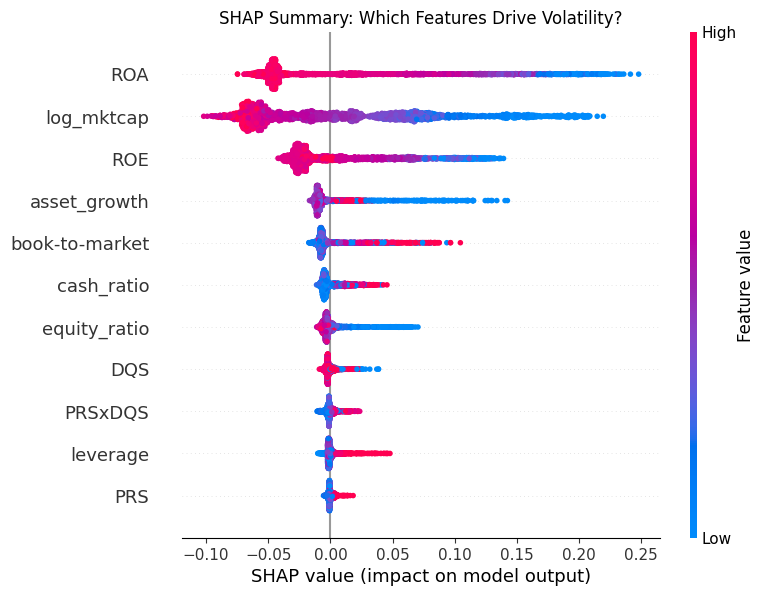

<Figure size 800x500 with 0 Axes>

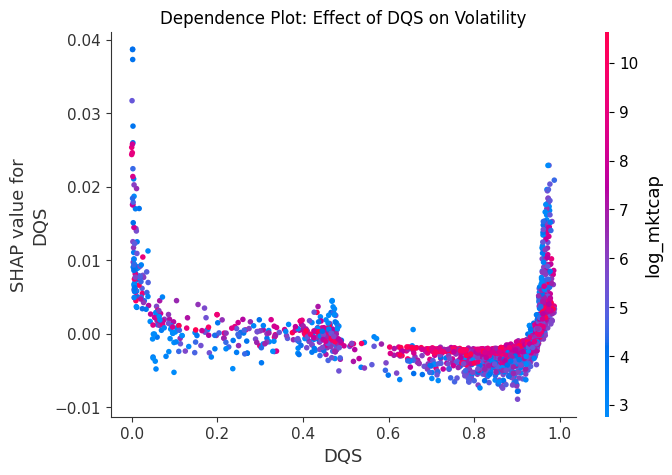

<Figure size 800x500 with 0 Axes>

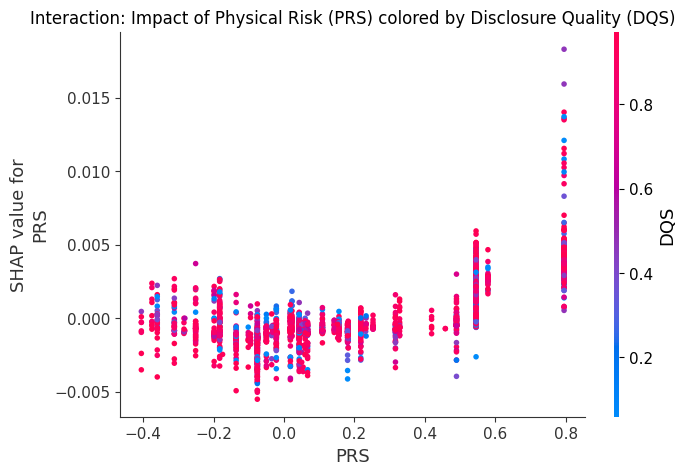

In [10]:
# 8. SHAP Analysis 
# -> reveal the direction and interaction effects (Does high DQS lower volatility? Does DQS affect high-risk companies differently?)
# Initialize Explainer (TreeExplainer is optimized for Random Forests)
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the TEST set
# (We want to see how the model treats unseen data)
shap_values = explainer.shap_values(X_test)

# A. Summary Plot (Global Importance + Direction)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary: Which Features Drive Volatility?")
plt.show()

# B. Dependence Plot: DQS vs Volatility
# Does the relationship look U-shaped? Is it flat?
plt.figure(figsize=(8, 5))
shap.dependence_plot("DQS", shap_values, X_test, show=False)
plt.title("Dependence Plot: Effect of DQS on Volatility")
plt.show()

# C. Interaction Plot: PRS vs DQS
# This is the money plot: How does Disclosure modify the market's reaction to Physical Risk?
# We plot SHAP values of PRS, colored by DQS.
plt.figure(figsize=(8, 5))
shap.dependence_plot(
    "PRS", 
    shap_values, 
    X_test, 
    interaction_index="DQS",
    show=False
)
plt.title("Interaction: Impact of Physical Risk (PRS) colored by Disclosure Quality (DQS)")
plt.show()

# Gradient Boosting Regressor (Predictive)

In [11]:

# ---------------------------------------------------------
# 1. Setup & Data (Reuse existing splits)
# ---------------------------------------------------------

print(f"Training on Dev Set: {X_dev.shape}")
print(f"Testing on Holdout:  {X_test.shape}")

# ---------------------------------------------------------
# 2. Define Model & Hyperparameters
# ---------------------------------------------------------
# GBR requires balancing 'learning_rate' with 'n_estimators'.
# Lower learning_rate (0.01) needs more trees (500+) but generalizes better.

gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 500],       # Boosting needs more iterations than RF
    'learning_rate': [0.01, 0.05, 0.1], # The "step size" of correction
    'max_depth': [3, 4, 5],           # Keep distinctively shallow (Boosting overfits deep trees)
    'subsample': [0.8, 1.0],          # Stochastic boosting (0.8) often robustifies against noise
    'min_samples_leaf': [10, 20]      # Regularization constraint
}

# ---------------------------------------------------------
# 3. Walk-Forward Grid Search
# ---------------------------------------------------------
# We use the EXACT same TimeSeriesSplit as the Random Forest for fair comparison
tscv = TimeSeriesSplit(n_splits=5)

gbr_grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Starting Gradient Boosting Walk-Forward Search...")
gbr_grid.fit(X_dev, y_dev)

print("\nBest GBR Parameters:")
print(gbr_grid.best_params_)

# ---------------------------------------------------------
# 4. Final Evaluation (Test Set)
# ---------------------------------------------------------
best_gbr = gbr_grid.best_estimator_
y_pred_test_gbr = best_gbr.predict(X_test)

r2_test_gbr = r2_score(y_test, y_pred_test_gbr)
rmse_test_gbr = np.sqrt(mean_squared_error(y_test, y_pred_test_gbr))

print("-" * 40)
print(f"Gradient Boosting Test R^2: {r2_test_gbr:.4f}")
print(f"Gradient Boosting Test RMSE: {rmse_test_gbr:.4f}")
print("-" * 40)


Training on Dev Set: (5909, 11)
Testing on Holdout:  (2228, 11)
Starting Gradient Boosting Walk-Forward Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best GBR Parameters:
{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 200, 'subsample': 0.8}
----------------------------------------
Gradient Boosting Test R^2: 0.3300
Gradient Boosting Test RMSE: 0.3107
----------------------------------------


In [18]:
# 7. Feature Importance (Gini) -> tells  "how often" a feature was used to make a decision, but not "how" (positive vs. negative).

importances = best_gbr.feature_importances_
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nGini Feature Importance:")
print(feat_imp)


Gini Feature Importance:
           feature  importance
6              ROA    0.440972
10      log_mktcap    0.198427
9       cash_ratio    0.097830
5     asset_growth    0.057943
8   book-to-market    0.042506
2          PRSxDQS    0.039408
1              DQS    0.037430
7              ROE    0.031551
4     equity_ratio    0.027454
3         leverage    0.019922
0              PRS    0.006558


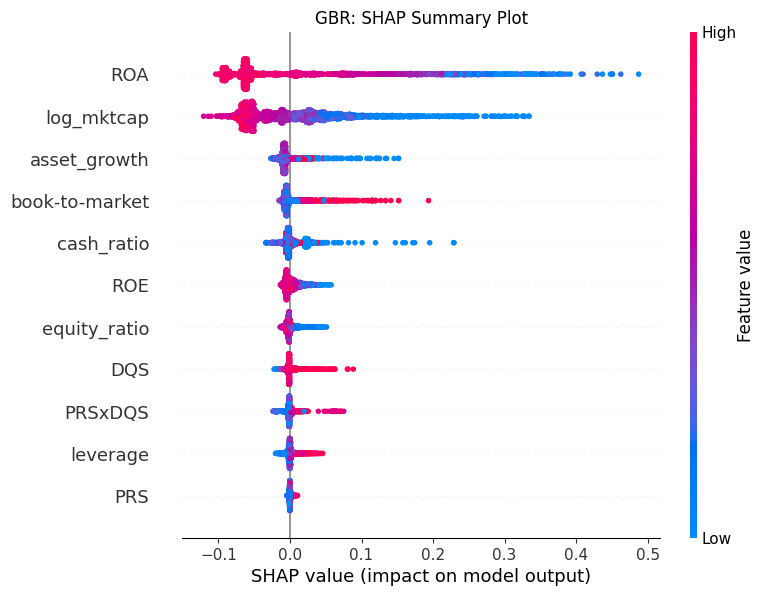

<Figure size 800x500 with 0 Axes>

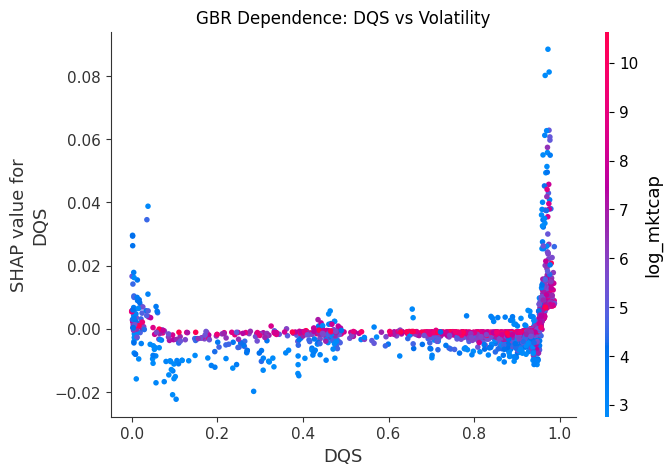

<Figure size 800x500 with 0 Axes>

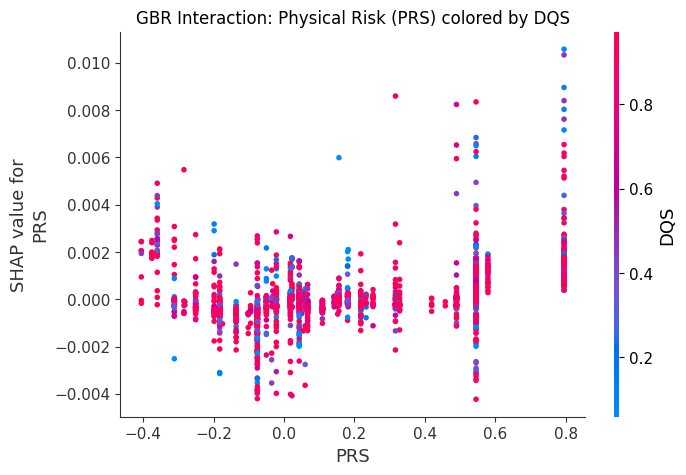

In [12]:
# ---------------------------------------------------------
# 5. SHAP Interpretability
# ---------------------------------------------------------
# Gradient Boosting is also tree-based, so we use TreeExplainer.
explainer_gbr = shap.TreeExplainer(best_gbr)
shap_values_gbr = explainer_gbr.shap_values(X_test)

# A. Summary Plot (Compare feature ranking vs RF)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_gbr, X_test, show=False)
plt.title("GBR: SHAP Summary Plot")
plt.show()

# B. DQS Non-Linearity (Compare the 'Smile' shape)
plt.figure(figsize=(8, 5))
shap.dependence_plot("DQS", shap_values_gbr, X_test, show=False)
plt.title("GBR Dependence: DQS vs Volatility")
plt.show()

# C. Interaction (PRS x DQS)
plt.figure(figsize=(8, 5))
shap.dependence_plot(
    "PRS", 
    shap_values_gbr, 
    X_test, 
    interaction_index="DQS",
    show=False
)
plt.title("GBR Interaction: Physical Risk (PRS) colored by DQS")
plt.show()

# ElasticNet Regression (predictive)

In [13]:
# ---------------------------------------------------------
# 3) Set up ElasticNet + Pipeline
# ---------------------------------------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    "model__alpha": np.logspace(-4, 2, 15),     # 1e-4 to 1e2
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# ---------------------------------------------------------
# 4) Grid Search with TimeSeriesSplit
# ---------------------------------------------------------
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,  # <--- HERE is the change: pass the TimeSeriesSplit object
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

# Fit on the Development set (2016-2022)
# The GridSearch will internally walk forward through this period to find the best params.
gcv.fit(X_dev, y_dev)

print("Best params:", gcv.best_params_)
print("Best Walk-Forward MSE:", -gcv.best_score_)

# ---------------------------------------------------------
# 5) Final Reality Check
# ---------------------------------------------------------
# Now apply the best model to the 2022-2023 holdout data
final_model = gcv.best_estimator_
test_score = final_model.score(X_test, y_test) # Returns R^2 by default
print(f"Final Test Score (R^2) on 2022-2023: {test_score:.4f}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best params: {'model__alpha': np.float64(0.013894954943731374), 'model__l1_ratio': 0.5}
Best Walk-Forward MSE: 0.15632037048649816
Final Test Score (R^2) on 2022-2023: 0.2688


In [14]:
best_model = gcv.best_estimator_

# Predict on the unseen Test set (2022-2023)
y_pred_test = best_model.predict(X_test)

# R^2 on Test
r2_test = r2_score(y_test, y_pred_test)

# RMSE on Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("-" * 30)
print(f"Final Test Set Performance (2022-2023)")
print("-" * 30)
print(f"R^2:  {r2_test:.3f}")
print(f"MSE:  {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

------------------------------
Final Test Set Performance (2022-2023)
------------------------------
R^2:  0.269
MSE:  0.1054
RMSE: 0.3246


In [15]:
# 5) Inspect Coefficients (Feature Importance)

# Retrieve the trained pipeline from the GridSearch result
best_pipeline = gcv.best_estimator_

# Extract the ElasticNet model from the pipeline step named "model"
enet = best_pipeline.named_steps["model"]

# Extract coefficients and intercept
coef = enet.coef_           # array of shape (n_features,)
intercept = enet.intercept_

# Create a DataFrame to view the results
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "abs_coef": np.abs(coef) # Helper to gauge magnitude (strength)
})

# Sort by raw coefficient value (Positive at top, Negative at bottom)
coef_df = coef_df.sort_values("coef", ascending=False)

print(f"Intercept: {intercept:.4f}")
print("-" * 30)
print(coef_df)

# --- Bonus: Sparsity Check ---
# ElasticNet (with l1_ratio=0.5) can shrink coefficients to exactly zero.
# Let's see how many features survived.
n_total = len(coef)
n_zero = np.sum(coef == 0)
n_active = n_total - n_zero

print("-" * 30)
print(f"Feature Selection: {n_active} features kept, {n_zero} features removed (set to 0).")

Intercept: 0.3175
------------------------------
           feature      coef  abs_coef
9       cash_ratio  0.034454  0.034454
2          PRSxDQS  0.005932  0.005932
0              PRS  0.004195  0.004195
3         leverage  0.002744  0.002744
5     asset_growth  0.000513  0.000513
1              DQS -0.000000  0.000000
7              ROE -0.000000  0.000000
8   book-to-market -0.000000  0.000000
4     equity_ratio -0.017623  0.017623
6              ROA -0.044410  0.044410
10      log_mktcap -0.108507  0.108507
------------------------------
Feature Selection: 8 features kept, 3 features removed (set to 0).


In [16]:
results = {
    "best_params": gcv.best_params_,
    "val_r2": r2_test,
    "val_rmse": rmse_test,
    "coef_df": coef_df,
    "intercept": intercept,
}

results 

{'best_params': {'model__alpha': np.float64(0.013894954943731374),
  'model__l1_ratio': 0.5},
 'val_r2': 0.26883403927595007,
 'val_rmse': np.float64(0.3245872707508171),
 'coef_df':            feature      coef  abs_coef
 9       cash_ratio  0.034454  0.034454
 2          PRSxDQS  0.005932  0.005932
 0              PRS  0.004195  0.004195
 3         leverage  0.002744  0.002744
 5     asset_growth  0.000513  0.000513
 1              DQS -0.000000  0.000000
 7              ROE -0.000000  0.000000
 8   book-to-market -0.000000  0.000000
 4     equity_ratio -0.017623  0.017623
 6              ROA -0.044410  0.044410
 10      log_mktcap -0.108507  0.108507,
 'intercept': np.float64(0.31747629686038464)}